In [1]:
%load_ext autoreload
%autoreload 2

In [86]:
# --- Standard library ---
import os
import sys
import time

# --- Scientific / data ---
import numpy as np
import pandas as pd
from scipy.sparse import csc_matrix

# --- Plotting ---
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm, Normalize
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.5

# --- Local modules ---
import pcms.haar
import pcms.stats
import pcms.tree
import utils

In [3]:
DATA = os.environ['DATA']
GN_DATA = os.path.join(DATA, 'guerrero_negro/')
GG_DATA = os.path.join(DATA, 'greengenes/gg_13_8_otus')
GG_TREES = os.path.join(GG_DATA, 'trees')
GG_OTU_MAPS = os.path.join(GG_DATA, 'otus')

## Part 1: Level of significance of Haar-like coordiantes of Guerrero Negro microbial mat dataset against 97% Greengenes tree

In [4]:
env_A = '1200.GN09P.o'
env_B = '1200.GN01P.o'

### Load 97% Greengenes tree

In [5]:
tree = pcms.tree.nwk2tree(os.path.join(GG_TREES, '97_otus.nwk'), ensure_planted=True)
n_leaves = tree.find_n_leaves()
seq_id2leaf_idx = utils.build_gg_seq_id2leaf_idx_map(tree)

In [6]:
intr_nodes = tree.find_interior_nodes()
tax_filepath = os.path.join(GG_DATA, 'taxonomy/97_otu_taxonomy.txt')

In [7]:
edge_lengths = tree.get_edge_length()
min_edge_length = np.min(edge_lengths[edge_lengths != 0])
print(f"Enforced minimum edge lenght: {min_edge_length}")

for node in range(tree.n_nodes):
    tree.set_edge_length(node, max(min_edge_length, tree.get_edge_length(node)))

Enforced minimum edge lenght: 0.0001


### Load Guerrero Negro dataset

In [8]:
gn_table_filepath = os.path.join(GN_DATA, "Harris et al. (2013)/454/47908_otu_table.tsv")
gn_table_df = utils.load_seq_id_abundances_from_biom_tsv(gn_table_filepath)

In [9]:
leaf_idxs = seq_id2leaf_idx[gn_table_df['OTU ID']].values
gn_table_df.loc[:, 'Leaf Index'] = leaf_idxs
gn_table_df.sort_values('Leaf Index', inplace=True, ignore_index=True)

In [10]:
print(gn_table_df.columns)

Index(['OTU ID', '1200.GN01P', '1200.GN01P.o', '1200.GN02P', '1200.GN02P.o',
       '1200.GN03P', '1200.GN03P.o', '1200.GN04P', '1200.GN04P.o',
       '1200.GN05P', '1200.GN05P.o', '1200.GN06P', '1200.GN06P.o',
       '1200.GN07P', '1200.GN07P.o', '1200.GN08P', '1200.GN08P.o',
       '1200.GN09P', '1200.GN09P.o', 'Leaf Index'],
      dtype='object')


In [11]:
gn_counts_df = gn_table_df.loc[(gn_table_df[env_A] != 0) | (gn_table_df[env_B] != 0), [env_A, env_B]]
gn_counts_df['Leaf Index'] = gn_table_df['Leaf Index']

# convert to relative abundances
cols = gn_counts_df.columns[:-1]
gn_rel_abund_df = gn_counts_df.copy()
gn_rel_abund_df[cols] = gn_counts_df[cols].div(gn_counts_df[cols].sum(axis=0), axis=1)

In [12]:
gn_counts_df

,1200.GN09P.o,1200.GN01P.o,Leaf Index
9,5,0,2520
10,6,0,2526
17,0,1,2549
20,0,1,2593
31,1,0,2662
...,...,...,...
1684,0,1,80733
1686,1,0,82314
1688,2,0,82499
1692,2,0,82516


In [13]:
gn_rel_abund_df

,1200.GN09P.o,1200.GN01P.o,Leaf Index
9,0.004941,0.000000,2520
10,0.005929,0.000000,2526
17,0.000000,0.000551,2549
20,0.000000,0.000551,2593
31,0.000988,0.000000,2662
...,...,...,...
1684,0.000000,0.000551,80733
1686,0.000988,0.000000,82314
1688,0.001976,0.000000,82499
1692,0.001976,0.000000,82516


### Compute Haar-like coordinates

In [14]:
Q, S = pcms.haar.sparsify(tree)

In [15]:
a_s = gn_rel_abund_df[env_A]
b_s = gn_rel_abund_df[env_B]

indices = gn_rel_abund_df['Leaf Index'].values
n_leaves = tree.find_n_leaves()

a_vals = a_s.values
a = np.zeros((n_leaves,))
a[indices] = a_vals

b_vals = b_s.values
b = np.zeros((n_leaves,))
b[indices] = b_vals

diff = a - b

In [16]:
hl_coords = Q.T @ diff
dh_comps = hl_coords**2 * S.diagonal()

In [17]:
S_coo = S.tocoo()
row, col, Svals = S_coo.row, S_coo.col, S_coo.data
hl_coords_i = hl_coords[row]
hl_coords_j = hl_coords[col]
contrib_data = Svals * hl_coords_i * hl_coords_j
M = csc_matrix((contrib_data, (row, col)), shape=S.shape)
M.eliminate_zeros()

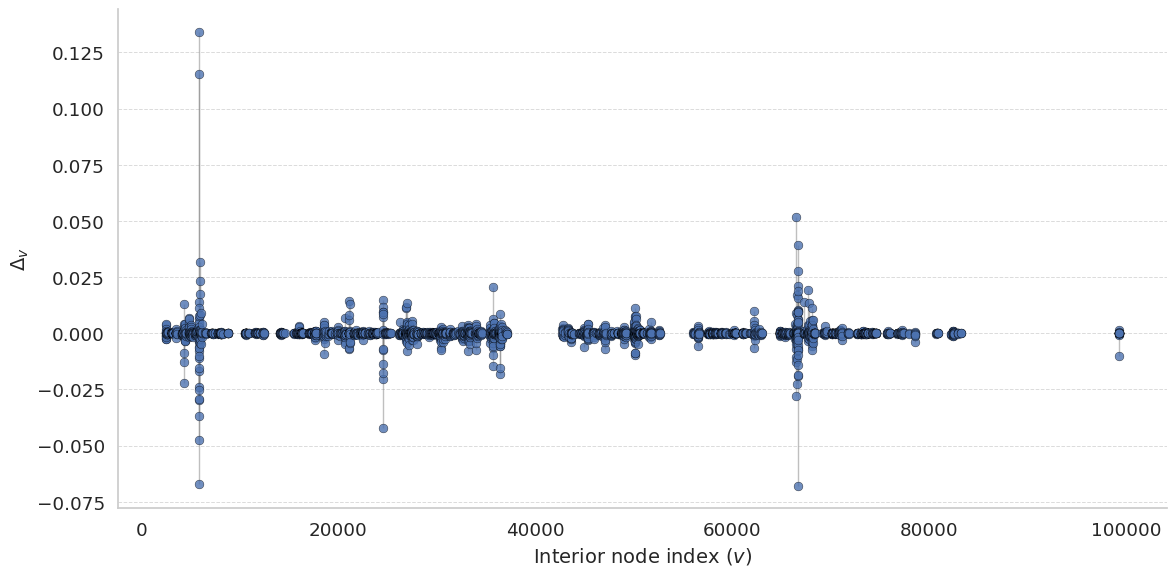

In [18]:
sns.set(style="whitegrid", font_scale=1.2)

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

idx = np.where(hl_coords)[0]
y = hl_coords[idx]
x = idx

# Scatter points colored by value with better aesthetics
ax.scatter(
    x, y,
    s=40,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3,
    zorder=3
)

# Draw vertical lines behind scatter points
ax.vlines(
    x=x,
    ymin=0,
    ymax=y,
    colors='gray',
    alpha=0.5,
    linewidth=1,
    zorder=1
)

# Improve axes labels
ax.set_xlabel('Interior node index ($v$)', fontsize=14)
ax.set_ylabel(r'$\Delta_v$', fontsize=14)

# Add a grid on y-axis only for clarity
ax.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax.xaxis.grid(False)

# Remove top and right spines for a cleaner look
sns.despine()

plt.tight_layout()
plt.show()

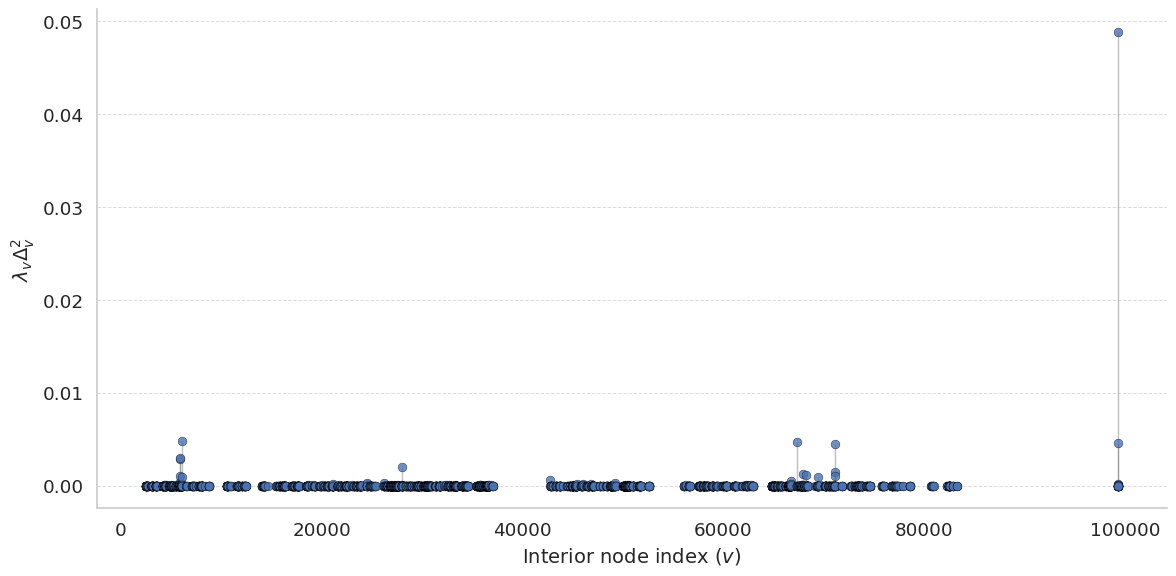

In [19]:
sns.set(style="whitegrid", font_scale=1.2)

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

idx = np.where(dh_comps)[0]
y = dh_comps[idx]
x = idx

# Scatter points with subtle edge for clarity
ax.scatter(
    x, y,
    s=40,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3,
    zorder=3
)

# Vertical lines behind scatter points
ax.vlines(
    x=x,
    ymin=0,
    ymax=y,
    colors='gray',
    alpha=0.5,
    linewidth=1,
    zorder=1
)

# Labels
ax.set_xlabel('Interior node index ($v$)', fontsize=14)
ax.set_ylabel(r'$\lambda_v \Delta_v^2$', fontsize=14)

# Grid: y-axis only
ax.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax.xaxis.grid(False)

# Remove top and right spines
sns.despine()

plt.tight_layout()
plt.show()

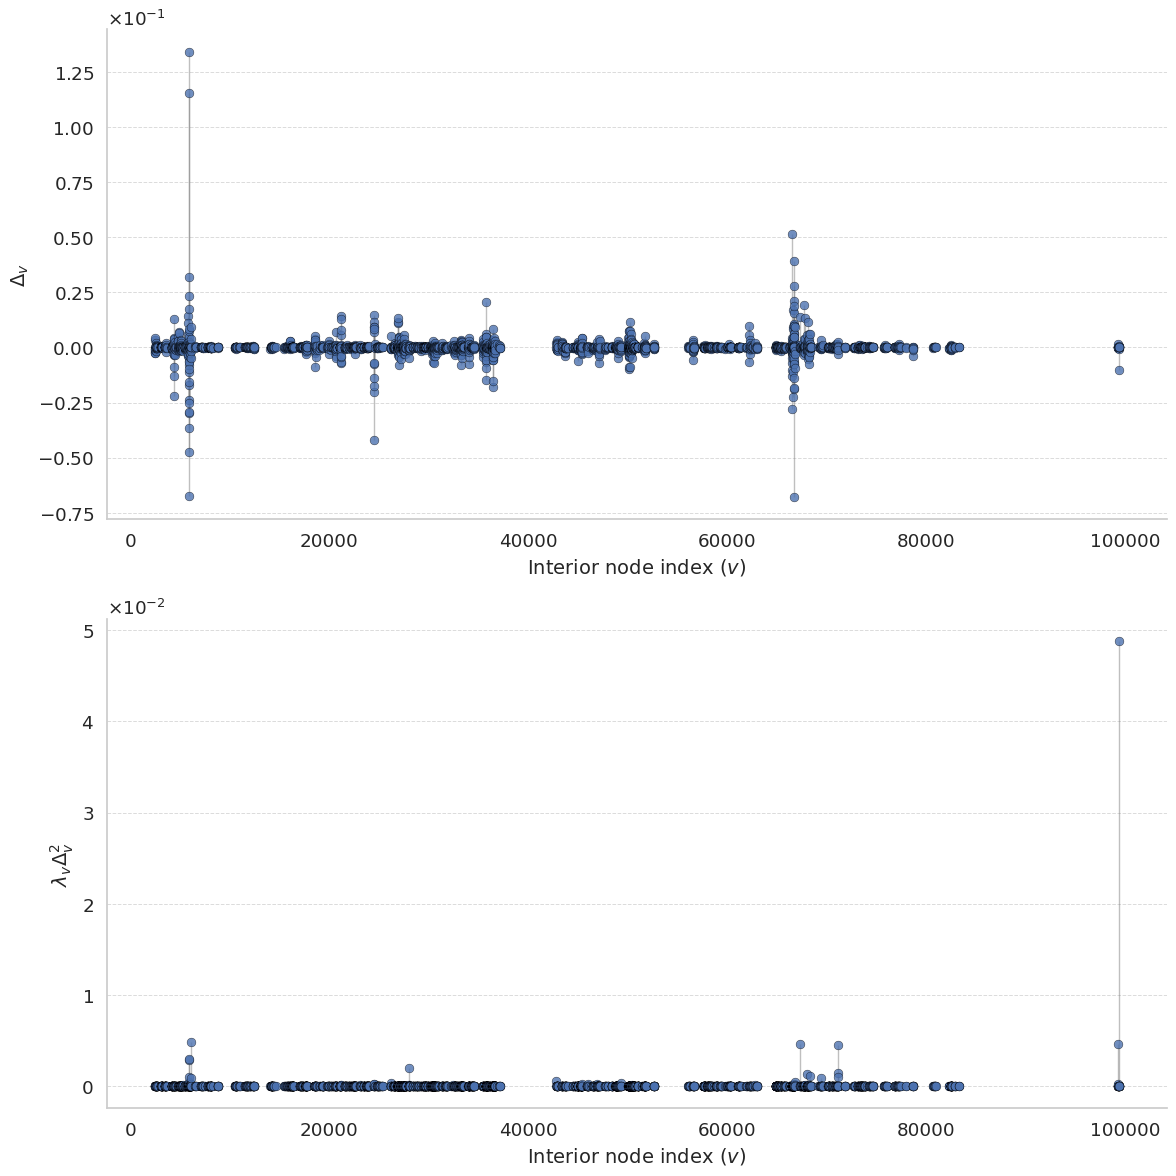

In [20]:
sns.set(style="whitegrid", font_scale=1.2)

# Create figure and two subplots side by side
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharey=False)

# --- Plot 1: coords plot ---
idx = np.where(hl_coords)[0]
y = hl_coords[idx]
x = idx

# Scatter points colored by value with better aesthetics
ax1.scatter(
    x, y,
    s=40,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3,
    zorder=3
)
# Draw vertical lines behind scatter points
ax1.vlines(
    x=x,
    ymin=0,
    ymax=y,
    colors='gray',
    alpha=0.5,
    linewidth=1,
    zorder=1
)
ax1.set_xlabel('Interior node index ($v$)', fontsize=14)
ax1.set_ylabel(r'$\Delta_v$', fontsize=14)
ax1.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax1.xaxis.grid(False)
ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
sns.despine(ax=ax1)

# --- Plot 2: dh_coords plot ---
idx = np.where(dh_comps)[0]
y = dh_comps[idx]
x = idx

# Scatter points with subtle edge for clarity
ax2.scatter(
    x, y,
    s=40,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3,
    zorder=3
)
# Vertical lines behind scatter points
ax2.vlines(
    x=x,
    ymin=0,
    ymax=y,
    colors='gray',
    alpha=0.5,
    linewidth=1,
    zorder=1
)
ax2.set_xlabel('Interior node index ($v$)', fontsize=14)
ax2.set_ylabel(r'$\lambda_v \Delta_v^2$', fontsize=14)
ax2.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax2.xaxis.grid(False)
ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
sns.despine(ax=ax2)

plt.tight_layout()
plt.show()

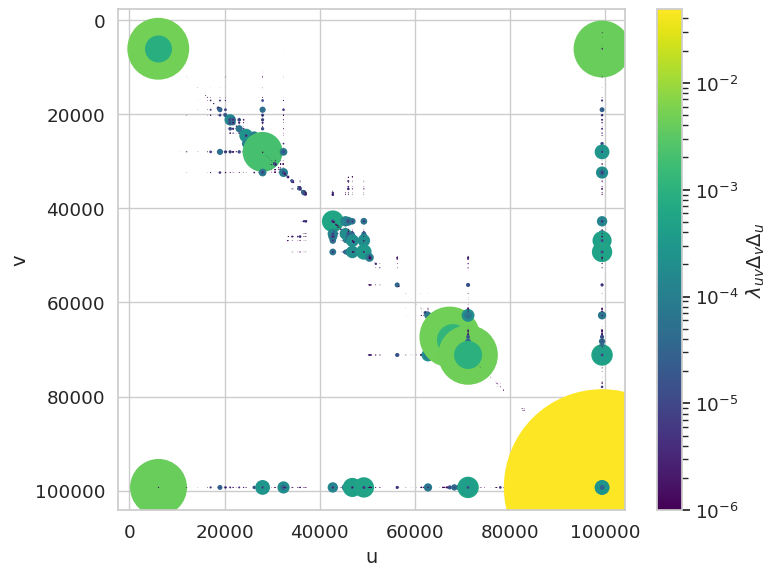

In [21]:
from matplotlib.colors import LogNorm

M_coo = M.tocoo()
rows, cols, vals = M_coo.row, M_coo.col, M_coo.data
vals = np.abs(vals)

scale_factor = 2e4
scale_power = 1
eps = 1e-6

fig, ax = plt.subplots(figsize=(8, 6))

sc = ax.scatter(
    cols, rows,
    c=vals,
    cmap="viridis",
    norm=LogNorm(vmin=max(vals.min(), eps), vmax=vals.max()),
    marker="o",
    s=scale_factor * (vals / vals.max()) ** scale_power,
    edgecolors='none'
)

ax.set_xlabel("u", fontsize=14)
ax.set_ylabel("v", fontsize=14)
ax.invert_yaxis()

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label(r"$\lambda_{uv}\Delta_v\Delta_u$", fontsize=14)

plt.tight_layout()
plt.show()

In [22]:
np.abs(np.sum(dh_comps) - np.sum(M.data)) / np.abs(np.sum(M.data))

np.float64(0.009765109328402823)

### Permutation Test

In [23]:
intr_nodes = tree.find_interior_nodes()
subtree_starts = tree.find_subtree_start_indices()
subtree_sizes = tree.get_subtree_size()

In [24]:
counts_ = gn_counts_df.iloc[:, :-1]
counts_ = np.asarray(counts_)
leaves = gn_counts_df['Leaf Index']
counts = np.zeros((tree.find_n_leaves(), 2))
counts[leaves, 0] = counts_[:, 0]
counts[leaves, 1] = counts_[:, 1]
counts = counts.astype(int)

In [25]:
mask = np.where(hl_coords != 0)[0]
node_idxs = intr_nodes[mask]
ys = np.abs(hl_coords[mask])

In [30]:
cdf_vals = pcms.stats.cdf_haar_coordinate_perm(
    ys,
    tree,
    node_idxs,
    counts,
    eps = 0.0001,
    delta = 0.01,
    batch_size = 100_000
)
pvals = 1 - cdf_vals

In [40]:
pvals.size - np.count_nonzero(pvals)

79

In [35]:
node2nz_idx = {nzidx : idx for idx, nzidx in enumerate(np.where(hl_coords != 0)[0])}
nz2node_idx = {idx : nzidx for idx, nzidx in enumerate(np.where(hl_coords != 0)[0])}

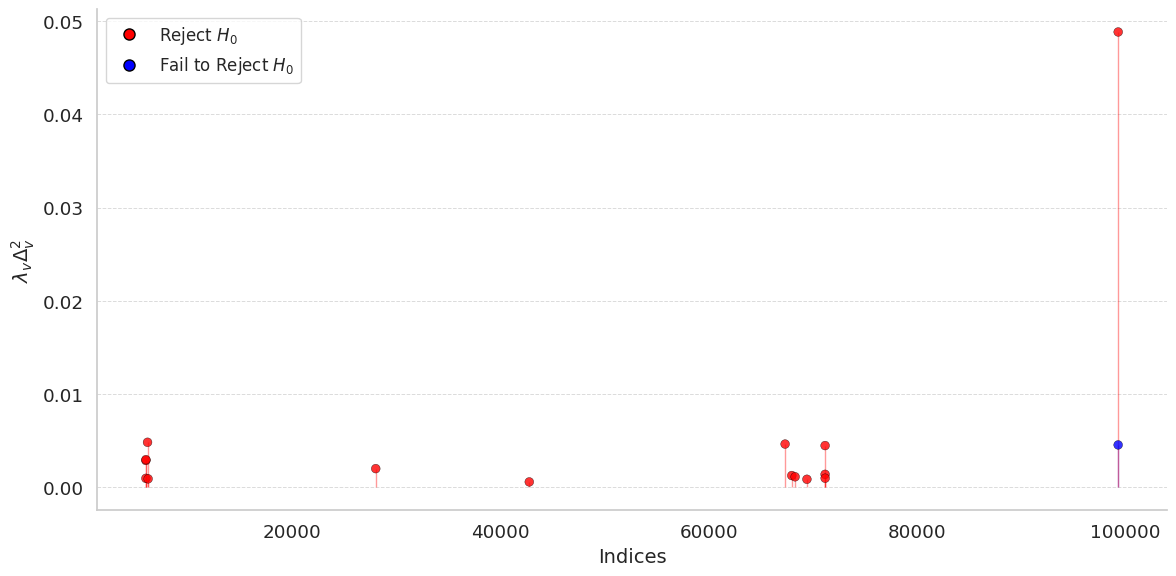

In [64]:
sns.set(style="whitegrid", font_scale=1.2)

fig, ax = plt.subplots(figsize=(12, 6))

alpha = 0.05
do_reject_dod = pvals < alpha

thresh = 5e-4

idx = np.where(dh_comps)[0]
idx_above_thresh = np.where(dh_comps[idx] > thresh)[0]
colors = np.where(do_reject_dod[idx_above_thresh], 'red', 'blue')
y = dh_comps[idx][idx_above_thresh]
x = idx[idx_above_thresh]

for xi, yi, ci in zip(x, y, colors):
    ax.vlines(xi, 0, yi, color=ci, alpha=0.4, linewidth=1.0, zorder=2)

scatter = ax.scatter(
    x, y,
    c=colors,
    s=40,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3,
    zorder=3
)

legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           label=r'Reject $H_0$', markerfacecolor='red',
           markeredgecolor='black', markersize=8),
    Line2D([0], [0], marker='o', color='w',
           label=r'Fail to Reject $H_0$', markerfacecolor='blue',
           markeredgecolor='black', markersize=8)
]
ax.legend(handles=legend_elements, frameon=True, fontsize=12)

ax.set_xlabel('Indices', fontsize=14)
ax.set_ylabel(r'$\lambda_v \Delta_v^2$', fontsize=14)
ax.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax.xaxis.grid(False)
sns.despine()

plt.tight_layout()
plt.show()

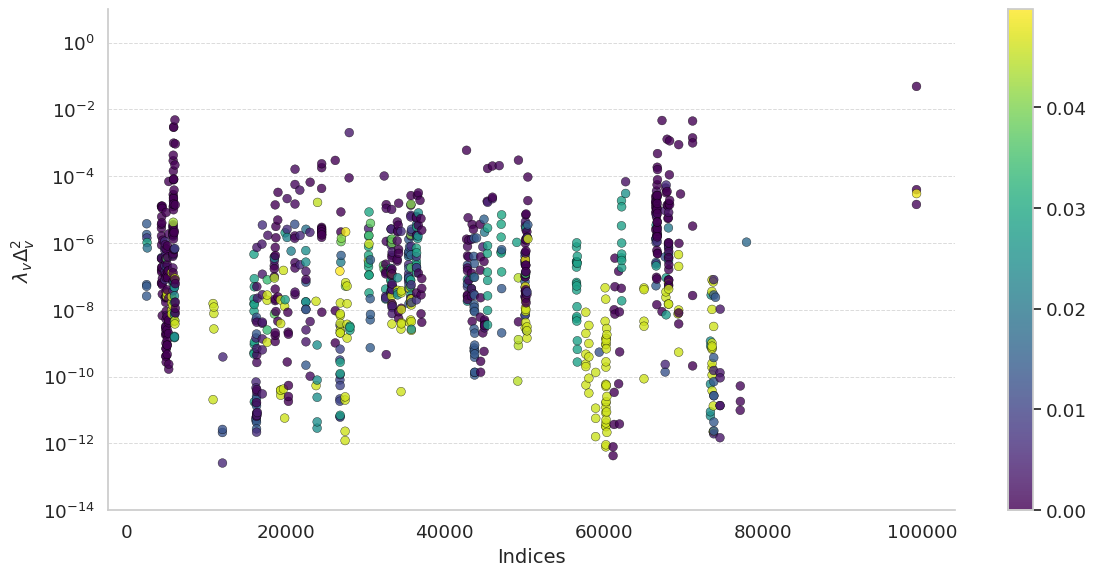

In [92]:
sns.set(style="whitegrid", font_scale=1.2)

fig, ax = plt.subplots(figsize=(12, 6))

thresh = 0.0
alpha = 0.05

idx = np.where(dh_comps)[0]
do_reject = np.where(pvals < alpha)[0]
y = dh_comps[idx][do_reject]
x = idx[do_reject]
c = pvals[do_reject]

scatter = ax.scatter(
    x, y,
    c=c,
    cmap='viridis',
    norm=Normalize(vmin=c.min(), vmax=c.max()),
    s=40,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3,
    zorder=3
)

ax.set_yscale('log')
ax.set_ylim([1e-14, 1e1])

fig.colorbar(scatter, ax=ax)

ax.set_xlabel('Indices', fontsize=14)
ax.set_ylabel(r'$\lambda_v \Delta_v^2$', fontsize=14)
ax.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax.xaxis.grid(False)
sns.despine()

plt.tight_layout()
plt.show()

In [66]:
N = 12

print(f"{'Index':>10} {'Subtree Size':>14} {'Split Size':>14} {'Component':>14} {'P-Value':>14}")
print("-" * 70)

sort_idx = np.argsort(dh_comps)[::-1]

eps = 0.0001
delta = 0.01
n_samples = np.ceil(1.0 / (2 * eps**2) * np.log(2 / delta))

for rank in range(N):
    idx = sort_idx[rank]
    node_idx = intr_nodes[idx]

    pval = pvals[node2nz_idx[idx]]
    pval = pval if pval > 0 else 1 / (n_samples + 1)

    children = tree.find_children(node_idx)
    split = np.min([tree.get_subtree_size(c) for c in children])

    print(
        f"{idx+1:>10d} "
        f"{subtree_sizes[node_idx]:>14d} "
        f"{split:>14d}"
        f"{dh_comps[idx]:>14.4f} "
        f"{pval:>14.3e}"
    )

     Index   Subtree Size     Split Size      Component        P-Value
----------------------------------------------------------------------
     99311          95297           2118        0.0488      3.775e-09
      6079           1792            769        0.0048      3.775e-09
     67317            835            270        0.0047      3.775e-09
     99307          50035          21893        0.0046      5.635e-02
     71160          14472           4899        0.0045      1.102e-06
      5923            600            272        0.0030      3.775e-09
      5921            240             87        0.0029      3.775e-09
     27998          20765           7640        0.0020      3.321e-03
     71159           4899           1513        0.0014      2.695e-06
     67959           1477            641        0.0013      3.775e-09
     68277           2017            215        0.0011      3.775e-09
     71165          21893           7003        0.0010      3.775e-09


In [93]:
np.save('../data/pvals.npy', pvals)

### Taxonomic classification of splits

In [80]:
def tax_of_split(tree, idx, abunds):
    intr_nodes = tree.find_interior_nodes()
    tax_map_left = utils.build_gg_otu_id2tax_map(tree, tax_filepath, node=tree.get_child(intr_nodes[idx]), abunds=abunds)
    tax_map_right = utils.build_gg_otu_id2tax_map(tree, tax_filepath, node=tree.get_sibling(tree.get_child(intr_nodes[idx])), abunds=abunds)
    return tax_map_left, tax_map_right


def truncate_lcr(lcr: str, max_ranks: int = 3) -> str:
    """
    Truncate an LCR string from the left by keeping only the last `max_ranks` ranks.
    Prepend with '...' if any ranks were removed.
    """
    ranks = lcr.split(';')
    if len(ranks) > max_ranks:
        # return '...;' + ';'.join(ranks[-max_ranks:])
        return ''.join(ranks[-max_ranks:])
    else:
        return lcr


def format_tax_table(tree, idxs, abunds, max_ranks=3, file=sys.stdout):
    node_blocks = []
    results = []  # <-- our structured data

    # First pass: collect truncated LCRs and abundance lines
    for idx in idxs:
        left, right = tax_of_split(tree, idx, abunds)
        left_abund_lines = [
            f"{tax}:{row.ref_fracs:.2f} ({row.abund_fracs:+.3f})"
            for tax, row in left['Fracs'].iterrows()
            if round(row.ref_fracs, 2) > 0.0
        ]
        right_abund_lines = [
            f"{tax}:{row.ref_fracs:.2f} ({row.abund_fracs:+.3f})"
            for tax, row in right['Fracs'].iterrows()
            if round(row.ref_fracs, 2) > 0.0
        ]

        left_lcr_trunc = truncate_lcr(left['LCR'], max_ranks)
        right_lcr_trunc = truncate_lcr(right['LCR'], max_ranks)

        # Keep for printing
        node_blocks.append((idx, left_lcr_trunc, right_lcr_trunc,
                            left_abund_lines, right_abund_lines))

        # Keep structured data
        results.append({
            "node": idx,
            "left": {
                "lcr": left_lcr_trunc,
                "abundances": [
                    {"taxon": tax.strip(),
                     "ref_frac": float(f"{row.ref_fracs:.2f}"),
                     "abund_frac": float(f"{row.abund_fracs:+.3f}")}
                    for tax, row in left['Fracs'].iterrows()
                    if round(row.ref_fracs, 2) > 0.0
                ]
            },
            "right": {
                "lcr": right_lcr_trunc,
                "abundances": [
                    {"taxon": tax.strip(),
                     "ref_frac": float(f"{row.ref_fracs:.2f}"),
                     "abund_frac": float(f"{row.abund_fracs:+.3f}")}
                    for tax, row in right['Fracs'].iterrows()
                    if round(row.ref_fracs, 2) > 0.0
                ]
            }
        })

    # Compute column widths across all nodes after truncation
    left_max_width = max(len(block[1]) for block in node_blocks)  # LCR
    right_max_width = max(len(block[2]) for block in node_blocks)
    for _, _, _, left_abund, right_abund in node_blocks:
        if left_abund:
            left_max_width = max(left_max_width, max(len(l) for l in left_abund))
        if right_abund:
            right_max_width = max(right_max_width, max(len(r) for r in right_abund))
    left_max_width += 4
    right_max_width += 4

    # Print table
    for idx, left_lcr, right_lcr, left_abund_lines, right_abund_lines in node_blocks:
        max_lines = max(len(left_abund_lines), len(right_abund_lines))
        left_abund_lines += [""] * (max_lines - len(left_abund_lines))
        right_abund_lines += [""] * (max_lines - len(right_abund_lines))

        print(f"Node {idx+1}", file=file)
        print(f"{'Left subtree':<{left_max_width}}{'Right subtree':<{right_max_width}}", file=file)
        print(f"{'-'*left_max_width}{'-'*right_max_width}", file=file)

        print(f"{left_lcr:<{left_max_width}}{right_lcr:<{right_max_width}}", file=file)
        for l_line, r_line in zip(left_abund_lines, right_abund_lines):
            print(f"{l_line:<{left_max_width}}{r_line:<{right_max_width}}", file=file)
        print("", file=file)

    return results

In [81]:
N = 12
idx = sort_idx[:N]
abunds = diff 
x = idx 
with open("../data/gn_tax_table_output.txt", "w") as f:
    gn_results = format_tax_table(tree, x, abunds=abunds, max_ranks=1, file=f)

In [82]:
def plot_split(ax, split_data, linthresh=1e-3, min_frac=1e-3, full_height=0.6):
    """
    Plot left and right abundances on the same axes, centered at 0.
    Each tree's taxa plotted independently (even if names overlap).
    """
    # Load data
    left_df = pd.DataFrame(split_data["left"]["abundances"])
    right_df = pd.DataFrame(split_data["right"]["abundances"])

    # Strip whitespace
    left_df["taxon"] = left_df["taxon"].str.strip()
    right_df["taxon"] = right_df["taxon"].str.strip()

    # Filter out small abundances
    left_df = left_df[np.abs(left_df["abund_frac"]) >= min_frac].copy()
    right_df = right_df[np.abs(right_df["abund_frac"]) >= min_frac].copy()

    # Diverging colormap
    colors = ["#b30c20", "#dd9595", "#9ed4f8", "#2166ac"]
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_div", colors, N=256)

    # Max absolute value for x-scale
    max_abs = max(left_df["abund_frac"].abs().max() if not left_df.empty else 0,
                  right_df["abund_frac"].abs().max() if not right_df.empty else 0)

    # Normalization for color
    def symlog_color_norm(x):
        x = np.array(x)
        sign = np.sign(x)
        log_scaled = np.log10(1 + np.abs(x)/linthresh)
        log_scaled /= np.log10(1 + max_abs/linthresh) if max_abs > 0 else 1
        log_scaled *= sign
        return (log_scaled + 1) / 2

    frac_to_color = lambda x: cmap(symlog_color_norm(x))

    # Sort each subtree independently
    left_df_sorted = left_df.sort_values("abund_frac")
    right_df_sorted = right_df.sort_values("abund_frac")

    # Assign y positions separately
    left_y = np.arange(len(left_df_sorted))
    right_y = np.arange(len(right_df_sorted))

    # Plot left bars
    for i, row in enumerate(left_df_sorted.itertuples()):
        ax.barh(
            left_y[i],
            row.abund_frac,
            color=frac_to_color(row.abund_frac),
            edgecolor="black",
            hatch="///",
            height=full_height,
            label=f"Left ({split_data['left']['lcr'].strip()})"
        )
    
    # Divider line for left tree
    if not left_df_sorted.empty:
        ax.axhline(len(left_df_sorted) - 0.5, color='gray', linestyle='--', linewidth=2)

    # Plot right bars
    for i, row in enumerate(right_df_sorted.itertuples()):
        ax.barh(
            right_y[i] + len(left_y),  # offset so right bars are below left bars
            row.abund_frac,
            color=frac_to_color(row.abund_frac),
            edgecolor="black",
            hatch="...",
            height=full_height,
            label=f"Right ({split_data['right']['lcr'].strip()})"
        )

    # Center line at 0
    ax.axvline(0, color="black", linewidth=0.8)

    # Y-axis labels (concatenate left + right taxa)
    ax.set_yticks(np.arange(len(left_y) + len(right_y)))
    ax.set_yticklabels(list(left_df_sorted["taxon"]) + list(right_df_sorted["taxon"]))

    # Legend (remove duplicates)
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

    ax.set_xlim(-max_abs - 0.1, max_abs + 0.1)

In [83]:
def rename_unclassified(results):
    for node in results:
        for side in ["left", "right"]:
            for abund in node[side]["abundances"]:
                tax = abund["taxon"].strip()
                if tax.endswith("__"):
                    prefix = tax[:3]  # e.g., "c__" or "p__"
                    abund["taxon"] = f"{prefix}Unclassified"

In [84]:
rename_unclassified(gn_results)

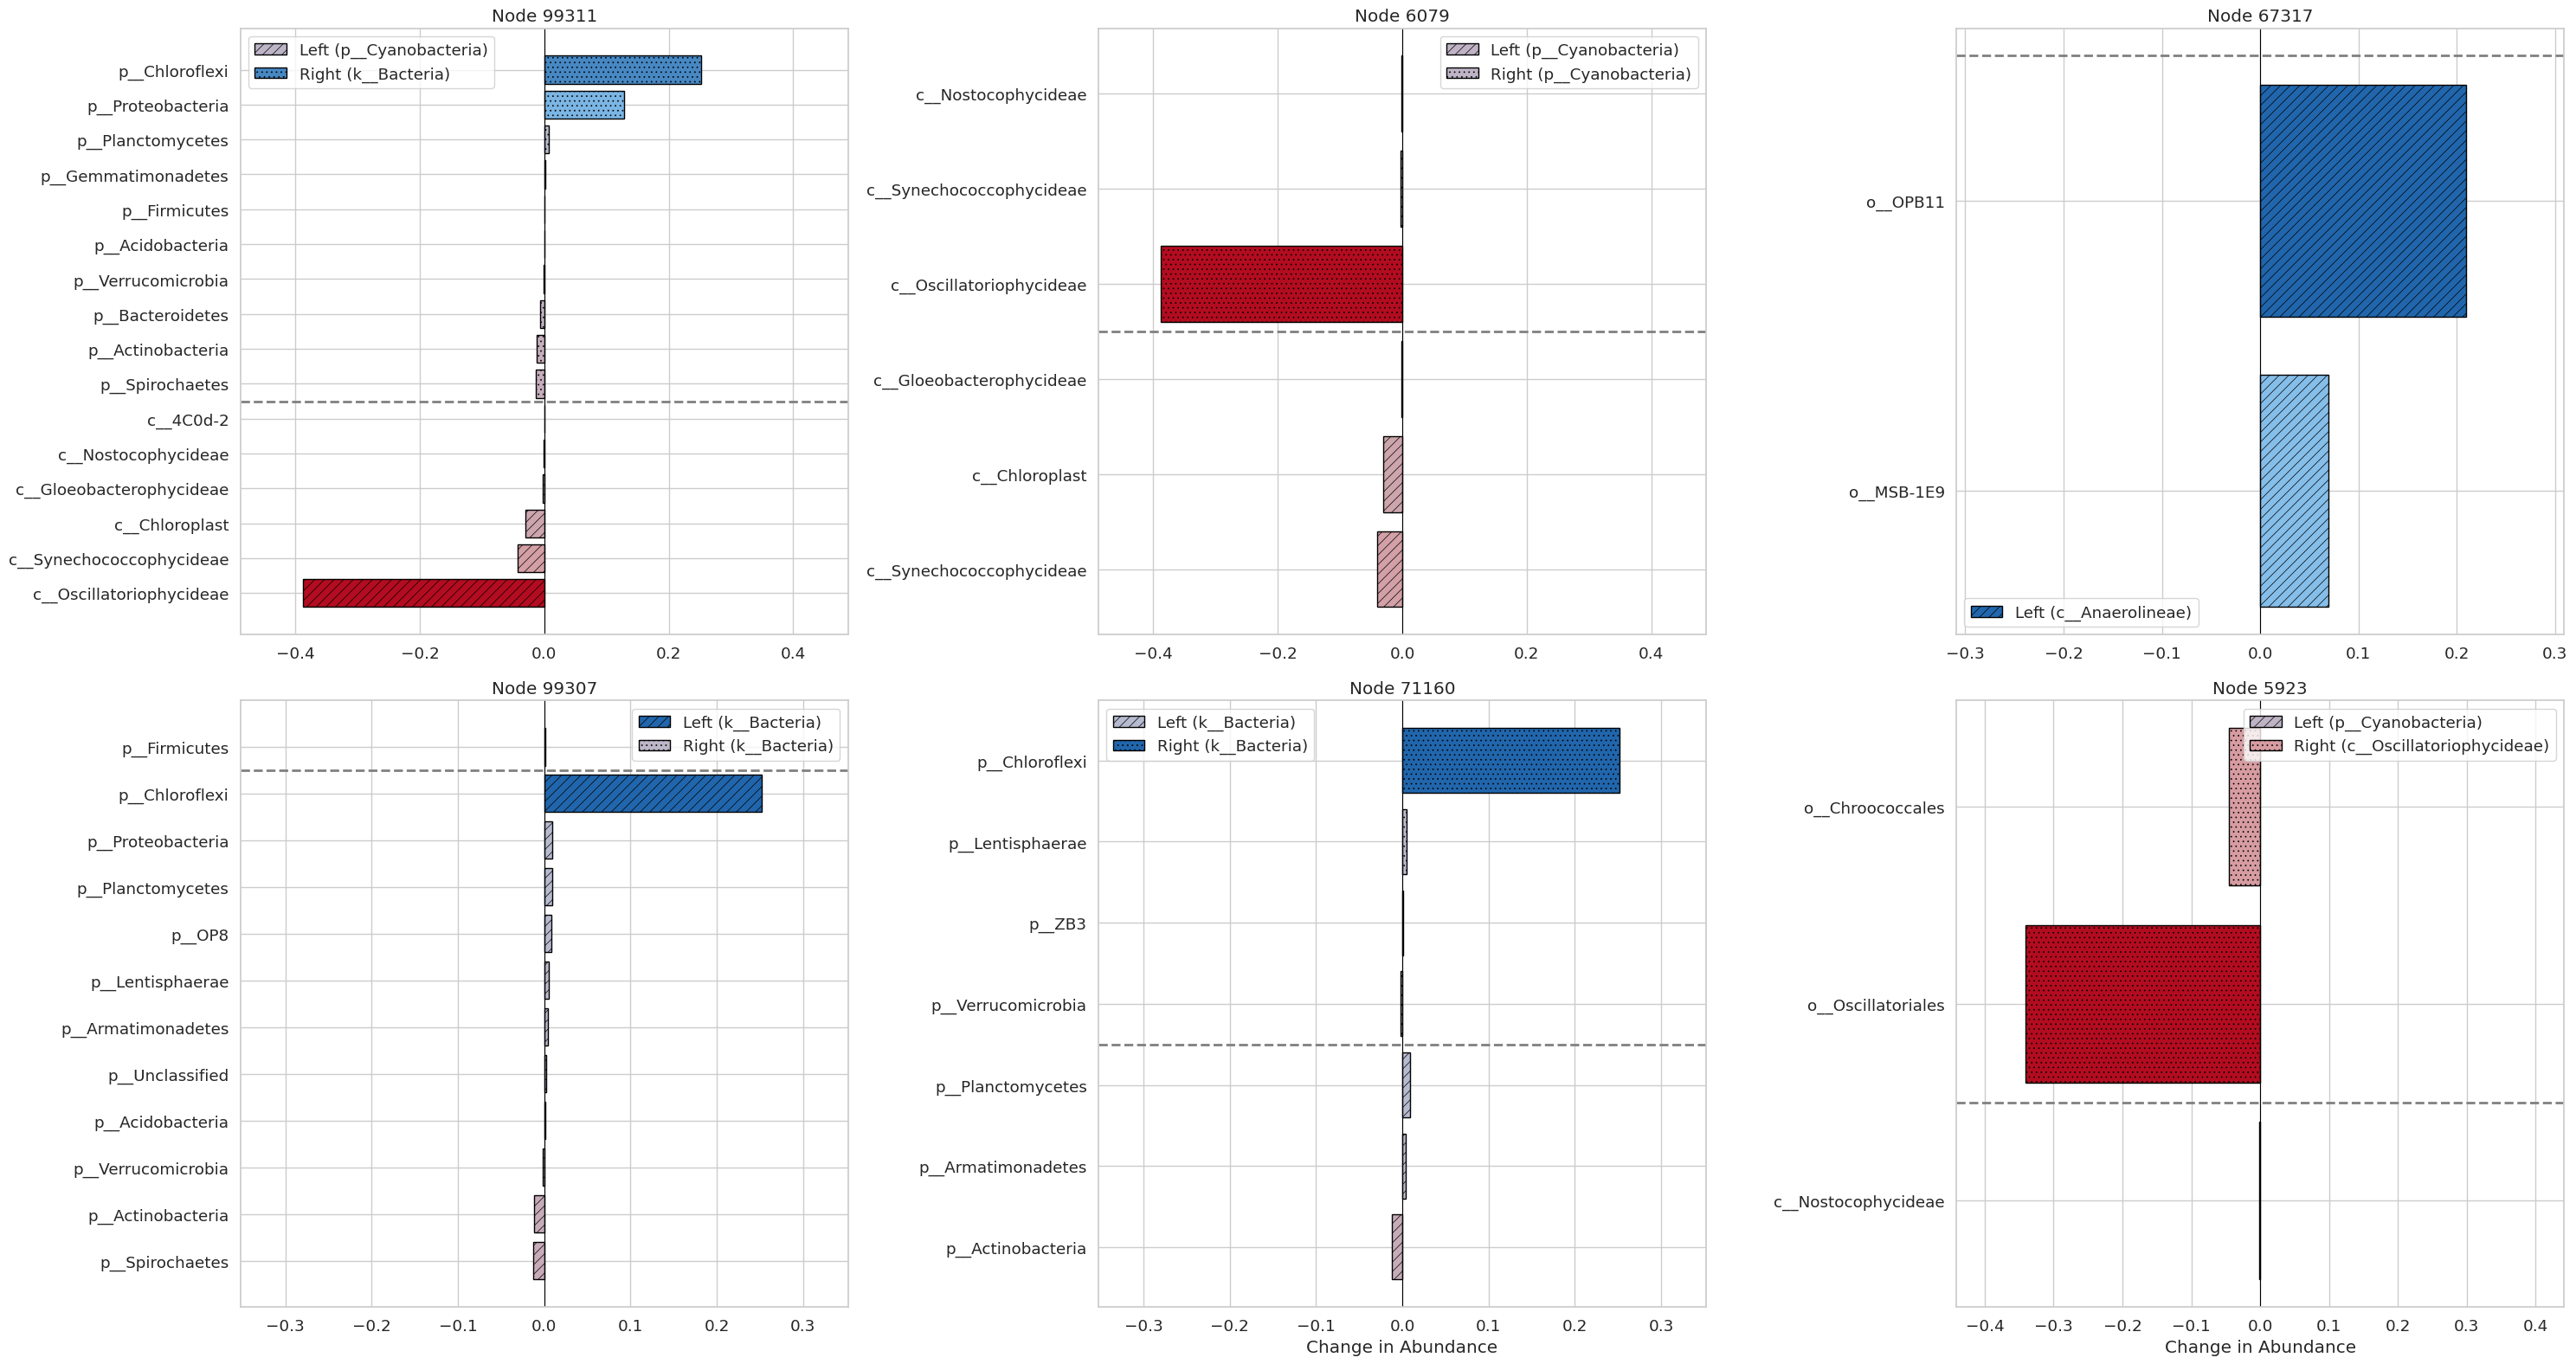

In [85]:
# Compute maximum number of taxa across all splits
max_n_taxa = 0
for split_data in gn_results[:6]:
    left_df = pd.DataFrame(split_data["left"]["abundances"])
    right_df = pd.DataFrame(split_data["right"]["abundances"])
    all_taxa = list(left_df["taxon"].str.strip()) + [
        t.strip() for t in right_df["taxon"] if t.strip() not in left_df["taxon"].str.strip().values
    ]
    max_n_taxa = max(max_n_taxa, len(all_taxa))

# Determine bar heights based on max_n_taxa
full_height =  0.8
overlap_height = full_height * 2/3

# Plot
fig, axes = plt.subplots(2, 3, figsize=(30, 16))
axes = axes.flatten()

for i, ax in enumerate(axes[:6]):
    split_data = gn_results[i]

    left_df = pd.DataFrame(split_data["left"]["abundances"])
    right_df = pd.DataFrame(split_data["right"]["abundances"])
    all_taxa = list(left_df["taxon"].str.strip()) + [t.strip() for t in right_df["taxon"] if t.strip() not in left_df["taxon"].str.strip().values]
    n_taxa = len(all_taxa)
    # scale = n_taxa / max_n_taxa
    scale = 1.0

    plot_split(
        ax, split_data, linthresh=1e-1, min_frac=1e-10,
        full_height=full_height * scale
    )
    ax.set_title(f"Node {split_data['node']+1}")

# X-axis labels for bottom row
axes[-2].set_xlabel('Change in Abundance')
axes[-1].set_xlabel('Change in Abundance')

plt.tight_layout()
plt.show()

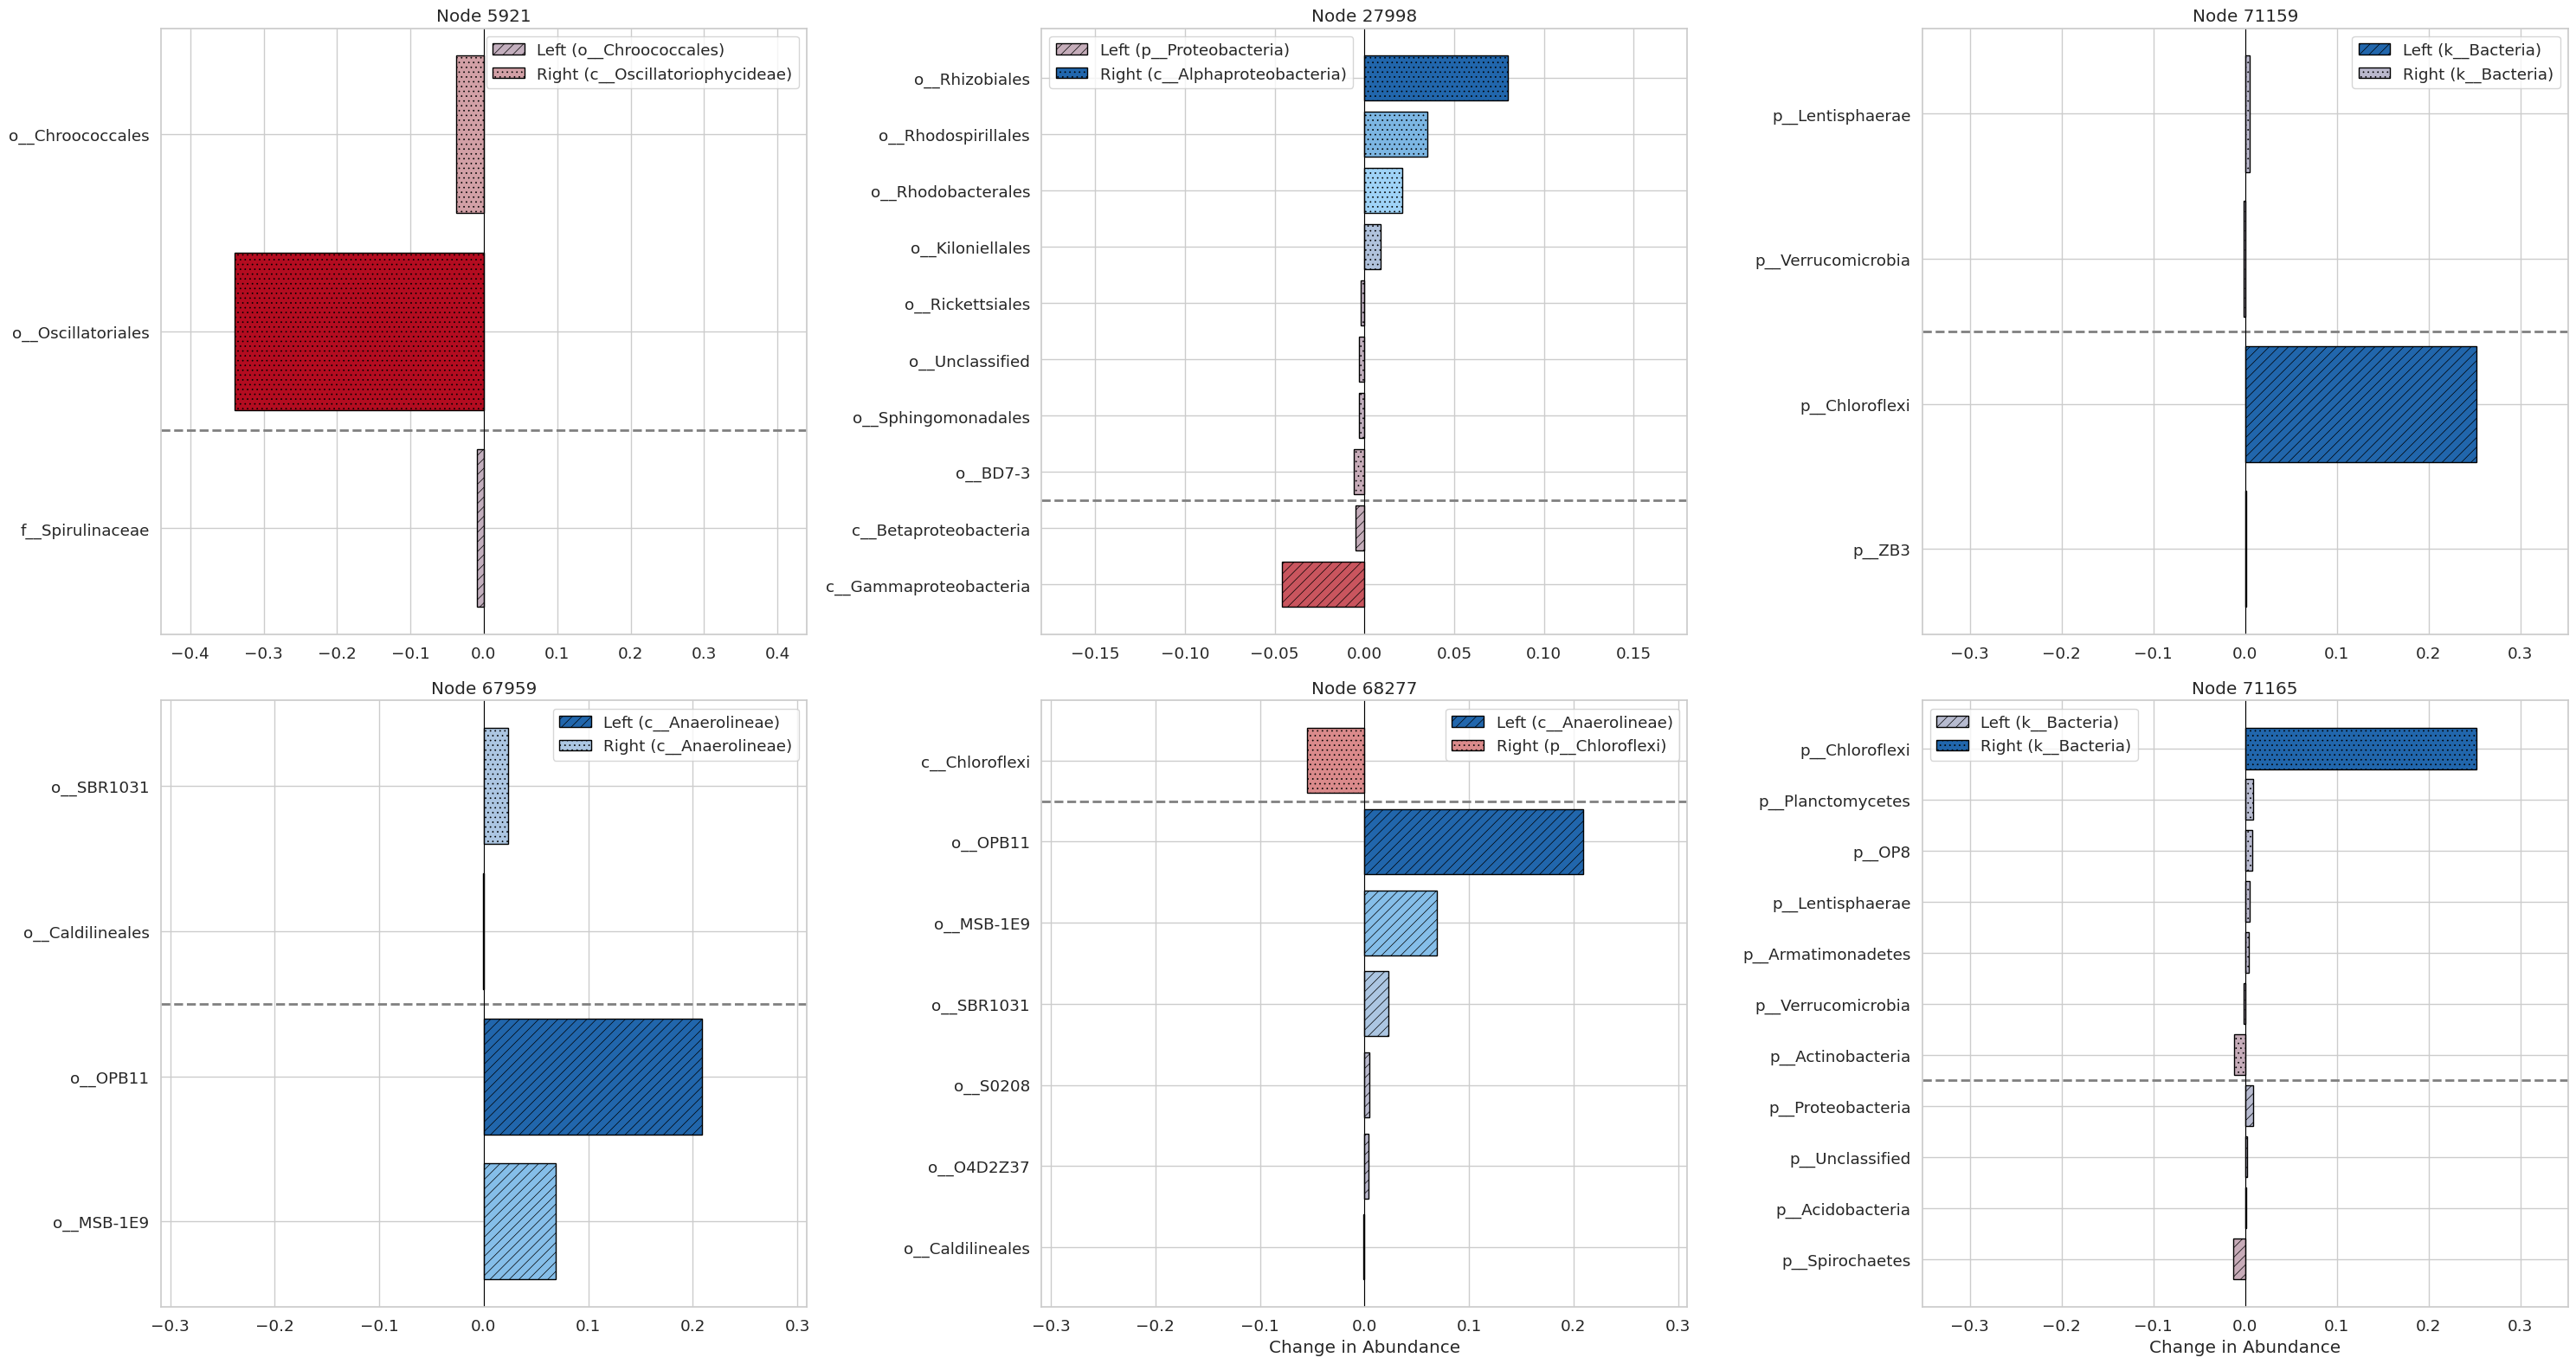

In [86]:
# Compute maximum number of taxa across all splits
max_n_taxa = 0
for split_data in gn_results[6:12]:
    left_df = pd.DataFrame(split_data["left"]["abundances"])
    right_df = pd.DataFrame(split_data["right"]["abundances"])
    all_taxa = list(left_df["taxon"].str.strip()) + [
        t.strip() for t in right_df["taxon"] if t.strip() not in left_df["taxon"].str.strip().values
    ]
    max_n_taxa = max(max_n_taxa, len(all_taxa))

# Determine bar heights based on max_n_taxa
full_height =  0.8
overlap_height = full_height * 2/3

# Plot
fig, axes = plt.subplots(2, 3, figsize=(30, 16))
axes = axes.flatten()

for i, ax in enumerate(axes[:6]):
    split_data = gn_results[i+6]

    left_df = pd.DataFrame(split_data["left"]["abundances"])
    right_df = pd.DataFrame(split_data["right"]["abundances"])
    all_taxa = list(left_df["taxon"].str.strip()) + [t.strip() for t in right_df["taxon"] if t.strip() not in left_df["taxon"].str.strip().values]
    n_taxa = len(all_taxa)
    # scale = n_taxa / max_n_taxa
    scale = 1.0

    plot_split(
        ax, split_data, linthresh=1e-1, min_frac=1e-10,
        full_height=full_height * scale
    )
    ax.set_title(f"Node {split_data['node']+1}")

# X-axis labels for bottom row
axes[-2].set_xlabel('Change in Abundance')
axes[-1].set_xlabel('Change in Abundance')

plt.tight_layout()
plt.show()